In [22]:
%matplotlib inline

In [23]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

Problem 1.

In [24]:
#squared loss function
def squared_loss(a,b, x, y, dy):
    model_y = a*x + b
    residuals = y - model_y
    return np.sum((residuals/dy) ** 2)

In [25]:
#fitting a line to the full sample
grid_a = np.linspace(0,5,100)
grid_b = np.linspace(-5,5,100)

values = np.zeros((len(grid_a), len(grid_b)))
for i, a in enumerate(grid_a):
    for j, b in enumerate(grid_b):
        values[i,j] = squared_loss(a,b ,x, y, dy)

val_min = np.unravel_index(np.argmin(values), values.shape)
val_min

a_best = grid_a[val_min[0]]
b_best = grid_b[val_min[1]]

print(f"a_best is:", a_best)
print(f"b_best is:", b_best)

a_best is: 2.121212121212121
b_best is: 5.0


In [26]:
#plot
plt.figure(figsize=(8,6))
plt.errorbar(x,y,yerr=dy,fmt = 'bo', label='Data with the Uncertainties(dy)')
plt.plot(x, a_best*x + b_best, 'r-', label='Best Fit Line')
plt.title("Grid Search for Best Fit Line")
plt.legend(loc='lower right')

In [27]:
residual = y - (a_best*x + b_best)
residual_std = np.std(residual)

#sigmaclipping

sigma = 3.0
mask = np.abs(residual) < sigma * residual_std
clean_x = x[mask]
clean_y = y[mask]
clean_dy = dy[mask]

In [28]:
values_clean = np.zeros((len(grid_a),len(grid_b)))

for i, a in enumerate(grid_a):
    for j, b in enumerate(grid_b):
        values_clean[i,j] = squared_loss(a,b ,clean_x, clean_y, clean_dy)

val_min_clean = np.unravel_index(np.argmin(values_clean), values_clean.shape)

a_best_clean = grid_a[val_min_clean[0]]
b_best_clean = grid_b[val_min_clean[1]]

print(f"a_best is:", a_best_clean)
print(f"b_best is:", b_best_clean)

a_best is: 2.121212121212121
b_best is: 5.0


In [29]:
plt.figure(figsize=(8,6))
plt.errorbar(clean_x,clean_y, yerr=clean_dy,fmt = 'bo', label='Data without the outliers')
plt.plot(clean_x, a_best_clean*clean_x + b_best_clean, 'r-', label='Best Fit Line')
plt.title("Grid Search for Best Fit Line")
plt.legend(loc='lower right')

In [30]:
#qqplot
residual2 = clean_y - (a_best_clean*clean_x + b_best_clean)
sm.qqplot(residual, line='45', fit='True')
plt.title("QQ Plot of Residuals")

Text(0.5, 1.0, 'QQ Plot of Residuals')

In [31]:
#robust likelihood function
def robust_likelihood_function(params,x, y,dy):
    a, b = params
    model = a*x + b
    residuals = (y - model)/dy
    return np.sum(np.log(1+0.5 * residuals**2) + np.log(dy))    

In [32]:
from scipy.optimize import minimize
guess = [2.1,5.0]
result_robust_likelihood_function = minimize(robust_likelihood_function, guess, args=(x, y, dy))
robust_a, robust_b = result_robust_likelihood_function.x
print(robust_a)
print(robust_b)
print(x.shape)
print(y.shape)
print(dy.shape)


2.1944416141116485
40.85279911135913
(20,)
(20,)
(20,)


In [33]:
robust_b

np.float64(40.85279911135913)

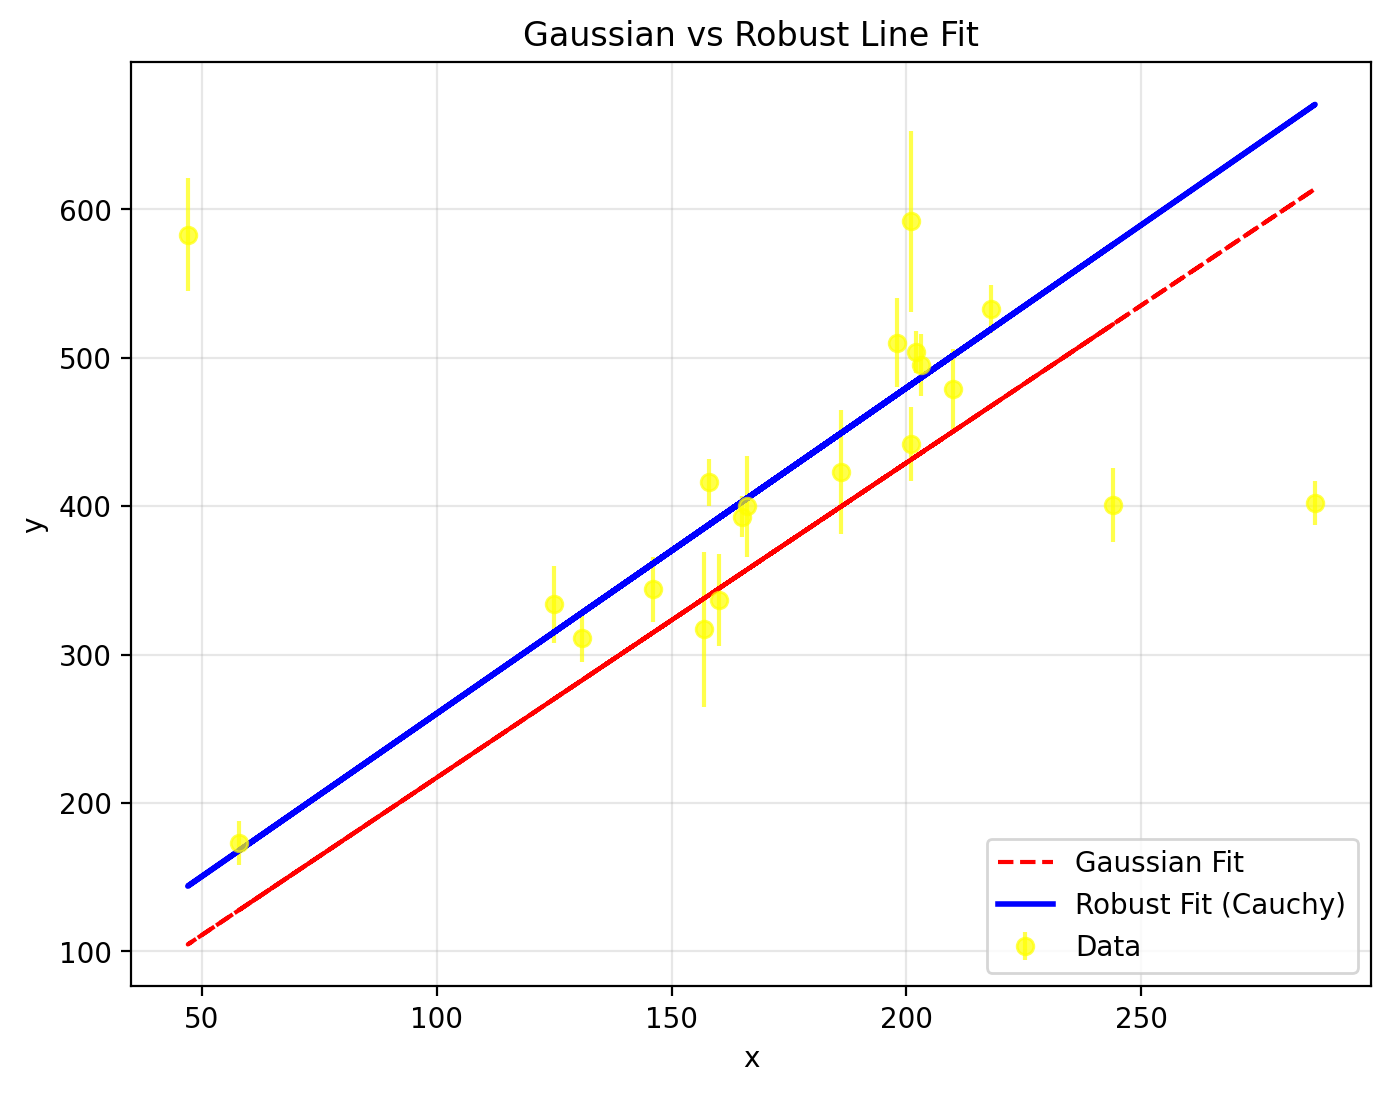

In [39]:

y_gaussian = a_best * x + b_best
y_robust = robust_a* x + robust_b

plt.figure(figsize=(8, 6))

plt.errorbar(x, y, yerr=dy, fmt='o', color='yellow', label='Data', alpha=0.7)

plt.plot(x, y_gaussian, 'r--', label='Gaussian Fit')

plt.plot(x, y_robust, 'b', label='Robust Fit (Cauchy)', linewidth=2)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Gaussian vs Robust Line Fit")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
